# Study the different embeddings of the trained transformer

### Start by loading the model 

In [1]:
# Add the relevant path for the root directory
import sys, os
sys.path.insert(0, "/Users/aurelien/PycharmProjects/spinorhelicity/")

In [2]:
from environment.utils import AttrDict
from environment import build_env
from model import build_modules

from environment.utils import to_cuda

In [3]:
# Define the trained model that we want to probed
model_path = '../experiments/npt6/checkpoint.pth'
assert os.path.isfile(model_path)

In [4]:
params = params = AttrDict({

'exp_name': 'Test_data_spin_hel',
        'dump_path': '/Users/aurelien/PycharmProjects/spinorhelicity/experiments/dumped/',
        'exp_id': 'test',
        'save_periodic': 0,
        'tasks': 'spin_hel',

        # environment parameters
        'env_name': 'char_env',
        'max_npt': 6,
        'max_scale': 2,
        'max_terms': 1,
        'max_scrambles': 5,
        'save_info_scr': True,
        'int_base': 10,
        'max_len': 2048,
        'canonical_form': True,
        'bracket_tokens': True,
        'generator_id': 2,
        'l_scale': 0.75,
        'numerical_check': False,

        # model parameters
        'emb_dim': 512,
        'n_enc_layers': 3,
        'n_dec_layers': 3,
        'n_heads': 8,
        'dropout': 0,
        'attention_dropout': 0,
        'sinusoidal_embeddings': False,
        'share_inout_emb': True,
        'reload_model': model_path,

        'amp': -1,
        'fp16': False,

        # CPU param
        'cpu': True,

})

In [5]:
env = build_env(params)
modules = build_modules(env, params)
encoder = modules['encoder']
decoder = modules['decoder']
encoder.eval()
decoder.eval()

TransformerModel(
  (position_embeddings): Embedding(2560, 512)
  (embeddings): Embedding(98, 512, padding_idx=1)
  (layer_norm_emb): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
  (attentions): ModuleList(
    (0): MultiHeadAttention(
      (q_lin): Linear(in_features=512, out_features=512, bias=True)
      (k_lin): Linear(in_features=512, out_features=512, bias=True)
      (v_lin): Linear(in_features=512, out_features=512, bias=True)
      (out_lin): Linear(in_features=512, out_features=512, bias=True)
    )
    (1): MultiHeadAttention(
      (q_lin): Linear(in_features=512, out_features=512, bias=True)
      (k_lin): Linear(in_features=512, out_features=512, bias=True)
      (v_lin): Linear(in_features=512, out_features=512, bias=True)
      (out_lin): Linear(in_features=512, out_features=512, bias=True)
    )
    (2): MultiHeadAttention(
      (q_lin): Linear(in_features=512, out_features=512, bias=True)
      (k_lin): Linear(in_features=512, out_features=512, bias=True)
 

In [6]:
import torch
import numpy as np

encoder.embeddings

Embedding(98, 512, padding_idx=1)

### Look at the embedding of the integers in the model

In [7]:
x1 = torch.LongTensor(
    [env.word2id[str(w)] for w in range(1,10)] 
).view(-1, 1).transpose(0, 1)

In [8]:
with torch.no_grad():
    tensor_integers = encoder.embeddings(x1)

##### Start with a simple PCA of the 512 embedding vectors

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_res2 = pca.fit_transform(tensor_integers.numpy()[0])
pca_res2

array([[ 1.3168917 ,  2.3178566 ],
       [ 2.3171563 , -0.4951869 ],
       [ 0.92069405, -1.0995768 ],
       [ 0.30792502, -0.95379543],
       [-0.42559987, -0.38996974],
       [-0.98341775, -0.30547985],
       [-1.1886483 ,  0.21481818],
       [-1.1198239 ,  0.18497461],
       [-1.1451708 ,  0.5263614 ]], dtype=float32)

In [10]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.3220858  0.20390739]
[0.3220858  0.52599317]


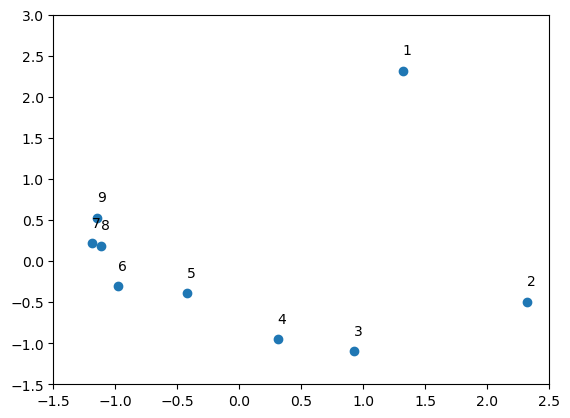

In [11]:
import matplotlib.pyplot as plt


plt.scatter(pca_res2[:,0], pca_res2[:,1])
  
# Loop for annotation of all points
for i in range(len(pca_res2[:,0])):
    plt.annotate(str(i+1), (pca_res2[i,0], pca_res2[i,1] + 0.2))

plt.xlim((-1.5, 2.5))
plt.ylim((-1.5, 3.0))
plt.show()


##### Now do a T-distributed Stochastic Neighbor Embedding

In [12]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(tensor_integers.numpy()[0])
X_embedded

array([[ 37.824455,  40.471825],
       [-65.022995, 151.06595 ],
       [-49.518467, 107.87815 ],
       [-31.316603,  74.35219 ],
       [-14.398226,  21.995825],
       [-23.265142, -28.360474],
       [-83.52638 , -41.13866 ],
       [-52.335194, -67.108444],
       [-77.91755 , -94.09438 ]], dtype=float32)

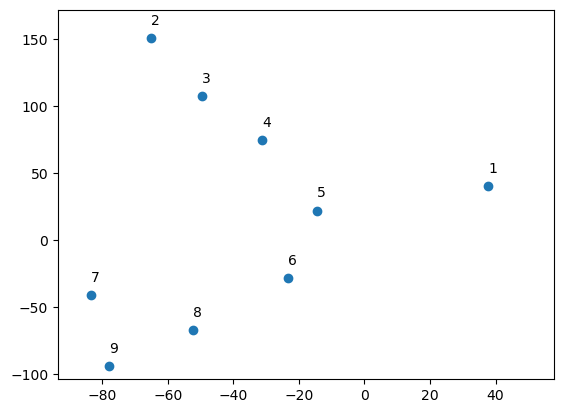

In [13]:

plt.scatter(X_embedded[:,0], X_embedded[:,1])
  
# Loop for annotation of all points
for i in range(len(X_embedded[:,0])):
    plt.annotate(str(i+1), (X_embedded[i,0], X_embedded[i,1] + 10))

plt.xlim((-10+np.min(X_embedded[:,0]), 10+np.max(X_embedded[:,0])+10))
plt.ylim((-10+np.min(X_embedded[:,1]), 10+np.max(X_embedded[:,1])+11))
plt.show()

### Look at the bracket embedding of the model

##### Sanity check for the bracket embeddings

Since we have used a canonical form throughout, the brackets with decreasing momentum labels should have not been learned

In [14]:
xbracketfull = torch.LongTensor(
    [env.word2id[str(w)] for w in env.special_tokens] 
).view(-1, 1).transpose(0, 1)

with torch.no_grad():
    tensor_bracket_full = encoder.embeddings(xbracketfull)

In [15]:
pca_bk_full = PCA(n_components=2)
pca_res_bk_full = pca_bk_full.fit_transform(tensor_bracket_full.numpy()[0])
print(pca_bk_full.explained_variance_ratio_)
print(pca_bk_full.explained_variance_ratio_.cumsum())

[0.07910343 0.04699548]
[0.07910343 0.12609892]


In [205]:
import seaborn as sns
color_points = [0 for i in range(int(len(env.special_tokens)/2))]+[1 for i in range(int(len(env.special_tokens)/2))]
my_cmap = ListedColormap(sns.color_palette()[0:2])

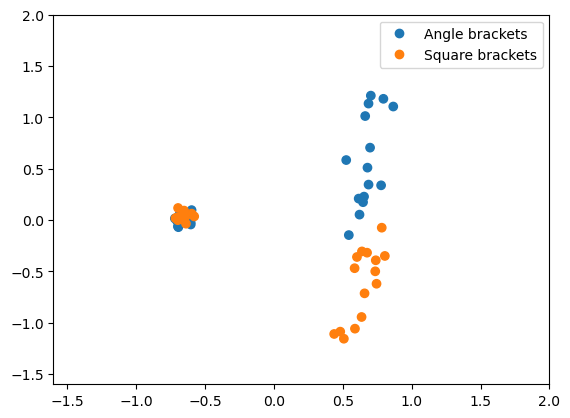

In [207]:
scatter_plt = plt.scatter(pca_res_bk_full[:,0], pca_res_bk_full[:,1], c=color_points, cmap=my_cmap)
  
plt.legend(handles=scatter_plt.legend_elements()[0], labels=['Angle brackets', 'Square brackets'])

plt.xlim((-1.6, 2))
plt.ylim((-1.6, 2))
plt.show()

As expected the embeddings that have not been used in training are clustered in their own subspace with no particular structure. The other learned embeddings have some inherent structure, where we can distinguish between the square and angle brackets in particular.

#####  Bracket embeddings

Now retain only the relevant brackets

In [18]:
tokens_red = [tok for tok in env.special_tokens if int(tok[-1]) > int(tok[-2])]

xbracketred = torch.LongTensor(
    [env.word2id[str(w)] for w in tokens_red] 
).view(-1, 1).transpose(0, 1)

with torch.no_grad():
    tensor_bracket_red = encoder.embeddings(xbracketred)

In [19]:
pca_bk_red = PCA(n_components=2)
pca_res_bk_red = pca_bk_red.fit_transform(tensor_bracket_red.numpy()[0])
print(pca_bk_red.explained_variance_ratio_)
print(pca_bk_red.explained_variance_ratio_.cumsum())

[0.05629425 0.04767282]
[0.05629425 0.10396707]


In [181]:
color_points_red = [list(sns.color_palette()[0]) for i in range(int(len(tokens_red)/2))]+[list(sns.color_palette()[1]) for i in range(int(len(tokens_red)/2))]

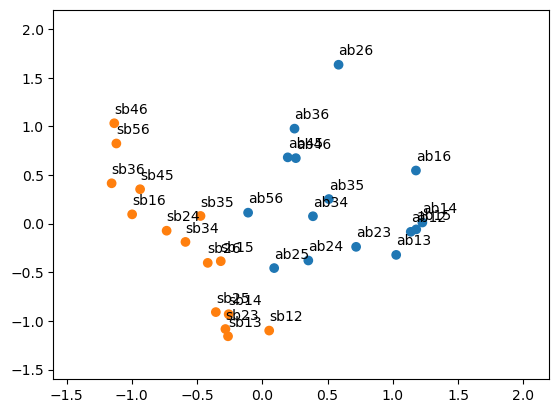

In [182]:
plt.scatter(pca_res_bk_red[:,0], pca_res_bk_red[:,1], c=color_points_red)
  
# Loop for annotation of all points
for i in range(len(pca_res_bk_red[:,0])):
    plt.annotate(tokens_red[i], (pca_res_bk_red[i,0], pca_res_bk_red[i,1] + 0.1))

plt.xlim((-1.6, 2.2))
plt.ylim((-1.6, 2.2))
plt.show()

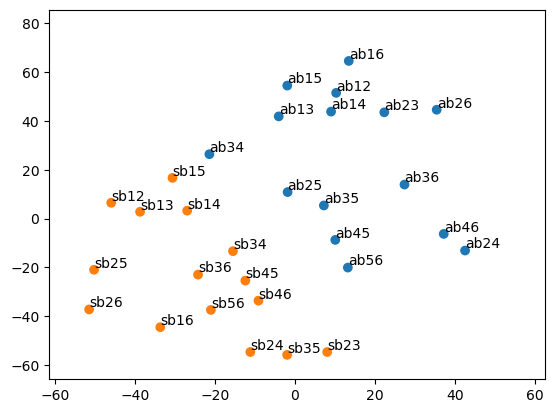

In [29]:
X_embedded_bk_red = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5).fit_transform(tensor_bracket_red.numpy()[0])

plt.scatter(X_embedded_bk_red[:,0], X_embedded_bk_red[:,1], c=color_points_red)
  
# Loop for annotation of all points
for i in range(len(X_embedded_bk_red[:,0])):
    plt.annotate(tokens_red[i], (X_embedded_bk_red[i,0], X_embedded_bk_red[i,1] + 1))

plt.xlim((-10+np.min(X_embedded_bk_red[:,0]), 10+np.max(X_embedded_bk_red[:,0])+10))
plt.ylim((-10+np.min(X_embedded_bk_red[:,1]), 10+np.max(X_embedded_bk_red[:,1])+11))
plt.show()

We have a clear distinction in the embedding space between the angle brackets and the square brackets
In general it seems like brackets with the same first momentum label a clustered near each other. Though it is hard to get a definite conclusion.

### Embedding at the equation level now

##### Define a path to the prefix file and read some equations from it

In [213]:
import random
random.seed(42)

in_path = '../experiments/npt6-infos/data.prefix.counts.valid'
load_num = 2500


with open(in_path) as infile:
    prefix_lists = random.sample([(line.split('\t')[0].split('|')[1]).split(' ') for line in infile],load_num)

##### Recover the different equation embeddings

In [214]:
encoded_eq = []
mean_encoded_eq = []
for prefix in prefix_lists:
    x1 = torch.LongTensor([env.eos_index] + [env.word2id[w] for w in prefix] + [env.eos_index]).view(-1, 1)
    len1 = torch.LongTensor([len(x1)])
    with torch.no_grad():
        encoded = encoder('fwd', x=x1, lengths=len1, causal=False)
        encoded_eq.append(torch.squeeze(encoded).numpy())
        mean_encoded_eq.append(torch.mean(torch.squeeze(encoded),0).numpy())

###### Recover the helicty and n_point properties of the expression

In [ ]:
from environment.utils import convert_sp_forms, get_helicity_expr, get_n_point

n_points = [get_n_point(env.infix_to_sympy(env.prefix_to_infix(prefix))) for prefix in prefix_lists]
helicities = [get_helicity_expr(convert_sp_forms(env.infix_to_sympy(env.prefix_to_infix(prefix)), env.func_dict), list(env.func_dict.values())) for prefix in prefix_lists]

##### Plot the PCA version and annotate either helicity or n_point

In [ ]:
pca_eqs = PCA(n_components=2)
pca_res_eqs = pca_eqs.fit_transform(np.array(mean_encoded_eq))

print(pca_eqs.explained_variance_ratio_)
print(pca_eqs.explained_variance_ratio_.cumsum())

X_embedded_eqs = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(np.array(mean_encoded_eq))

In [ ]:
from matplotlib.colors import ListedColormap
import colorcet as cc


true_max = max([hel for hel in helicities if not isinstance(hel, str)])
helicities2 = [true_max+1 if isinstance(hel, str) else hel for hel in helicities]

min_h = min(helicities2)
color_val =np.array(helicities2)+abs(min_h)
hel_list = list(np.unique(np.array(helicities2)))
counts_hel = [helicities2.count(un) for un in hel_list]

my_cmap = ListedColormap(sns.color_palette(cc.glasbey, n_colors=len(hel_list)))

In [ ]:
num_cutoff = 250
mask_hel = [1 if count > num_cutoff else 0 for count in counts_hel]
filter_index = [i for i, hel in enumerate(helicities2) if mask_hel[hel_list.index(hel)]==1]
hel_filter = [i for i, hel in enumerate(hel_list) if mask_hel[hel_list.index(hel)]==1]

hel_list2 = hel_list.copy()
hel_list2[-1] = 'N/A' if hel_list[-1] > true_max else hel_list[-1]

scatter = plt.scatter(pca_res_eqs[filter_index,0], pca_res_eqs[filter_index,1], c=color_val[filter_index], cmap=my_cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.array(hel_list2)[hel_filter]))
plt.show()

In [ ]:
scatter = plt.scatter(X_embedded_eqs[filter_index,0], X_embedded_eqs[filter_index,1], c=color_val[filter_index], cmap=my_cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.array(hel_list2)[hel_filter]))
plt.show()

In [ ]:
color_val =np.array(n_points)
my_cmap = ListedColormap(sns.color_palette(cc.glasbey, n_colors=len(color_val)))

scatter = plt.scatter(pca_res_eqs[:,0], pca_res_eqs[:,1], c=color_val, cmap=my_cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(np.array(n_points))))
plt.show()

In [ ]:
scatter = plt.scatter(X_embedded_eqs[:,0], X_embedded_eqs[:,1], c=color_val, cmap=my_cmap)
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(np.array(n_points))))
plt.show()

In [209]:
from environment.utils import convert_sp_forms
pre1 = 'mul pow ab12 INT- 1 mul pow ab13 INT- 1 mul pow ab14 INT- 1 add mul pow ab13 INT+ 3 mul ab14 sb13 add mul pow ab13 INT+ 2 mul ab12 mul ab14 sb12 add mul pow ab24 INT+ 2 mul ab13 mul ab23 sb23 add mul INT- 1 mul pow ab23 INT+ 2 mul ab14 mul ab24 sb23 mul INT- 1 mul ab12 mul ab14 mul ab23 mul ab24 sb12'
sp1 = convert_sp_forms(env.infix_to_sympy(env.prefix_to_infix(pre1.split(' '))), env.func_dict)

pre2 = 'mul INT- 1 mul pow ab12 INT- 1 mul ab13 mul ab14 sb14'
sp2 = convert_sp_forms(env.infix_to_sympy(env.prefix_to_infix(pre2.split(' '))), env.func_dict)

In [211]:
sp1

(ab(1, 2)*ab(1, 3)**2*ab(1, 4)*sb(1, 2) - ab(1, 2)*ab(1, 4)*ab(2, 3)*ab(2, 4)*sb(1, 2) + ab(1, 3)**3*ab(1, 4)*sb(1, 3) + ab(1, 3)*ab(2, 3)*ab(2, 4)**2*sb(2, 3) - ab(1, 4)*ab(2, 3)**2*ab(2, 4)*sb(2, 3))/(ab(1, 2)*ab(1, 3)*ab(1, 4))

In [212]:
sp2

-ab(1, 3)*ab(1, 4)*sb(1, 4)/ab(1, 2)